# Projet - Outils de programmation avancée pour l’IA

### Thématique : Classification d'Images Médicales pour la Détection de Tumeurs Cérébrales.

4 Classes disponibles :

*   notumor : Aucune tumeur détectée.
*   pituitary : Tumeurs de la glande pituitaire.
*   glioma : Tumeurs du cerveau, généralement liées aux cellules gliales.
*   meningioma : Tumeurs issues des méninges.


Réalisé par :

*   Youcef NAMOUN
*   Aziz BENMANSEUR

Encardé par : Prof. M. Ammi

### Code:

### Import des librairies

In [64]:
import kagglehub
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import glob
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import keras
import random
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import load_img, img_to_array

### Chargement des données

In [65]:
# Télécharger les données
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# Chemin des sous-dossiers
train_dir = f"{path}/Training"
test_dir = f"{path}/Testing"

# Liste des classes d'entrainement
train_classes = os.listdir(train_dir)
print("Classes disponibles dans les données d'entrainement :", train_classes)

# Liste des classes de test
test_classes = os.listdir(train_dir)
print("Classes disponibles dans les données de test :", test_classes)

Classes disponibles dans les données d'entrainement : ['pituitary', 'meningioma', 'glioma', 'notumor']
Classes disponibles dans les données de test : ['pituitary', 'meningioma', 'glioma', 'notumor']


### Visualisation des données

Affichages des images

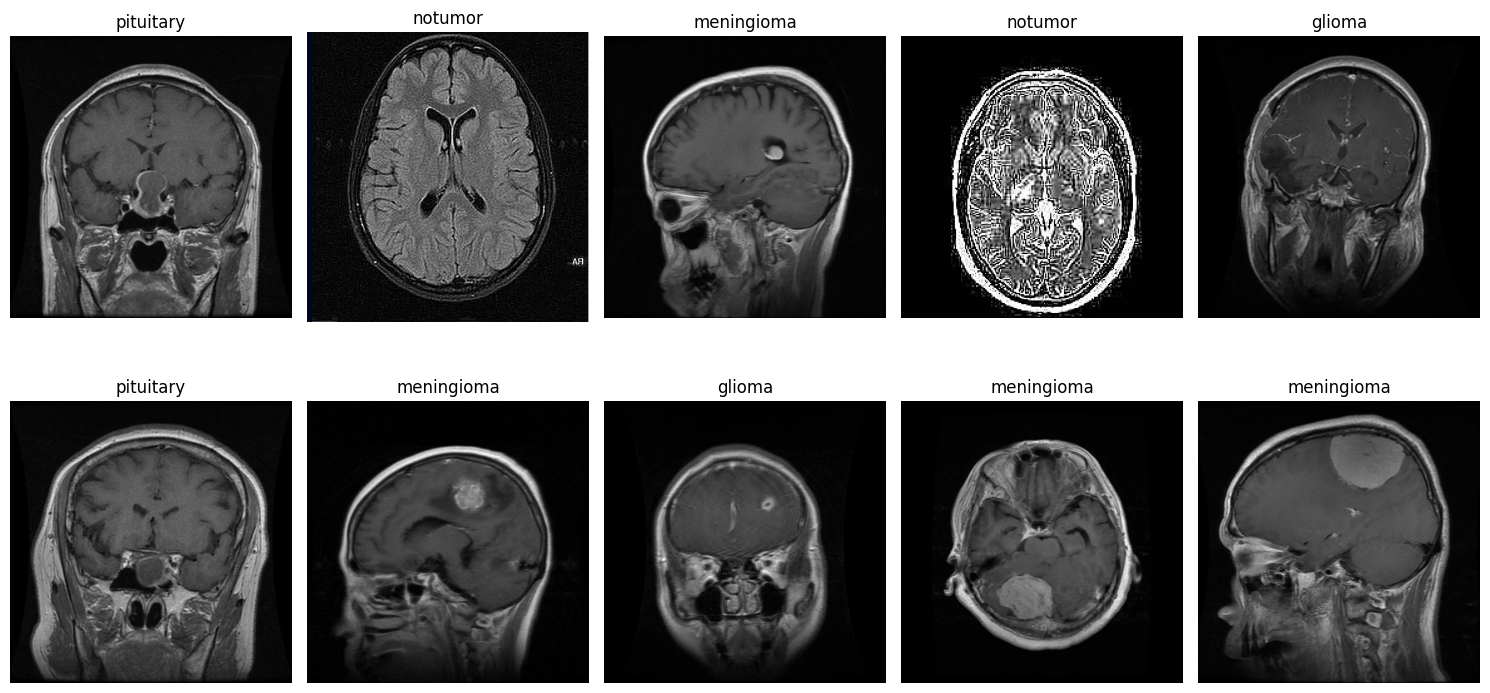

In [66]:
# Récupère tous les chemins des images dans le répertoire d'entraînement
all_images = glob.glob(f"{train_dir}/*/*.*")

# Sélectionne aléatoirement 10 images
images = random.sample(all_images, 10)

# Crée une figure avec 2 rangées et 5 colonnes pour afficher les images
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Parcourt les images et les affiche avec leur label
for ax, img_path in zip(axes.flatten(), images):
    img = tf.keras.utils.load_img(img_path)
    label = os.path.basename(os.path.dirname(img_path))
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

# Affiche les images
plt.tight_layout()
plt.show()

Distributions des classes

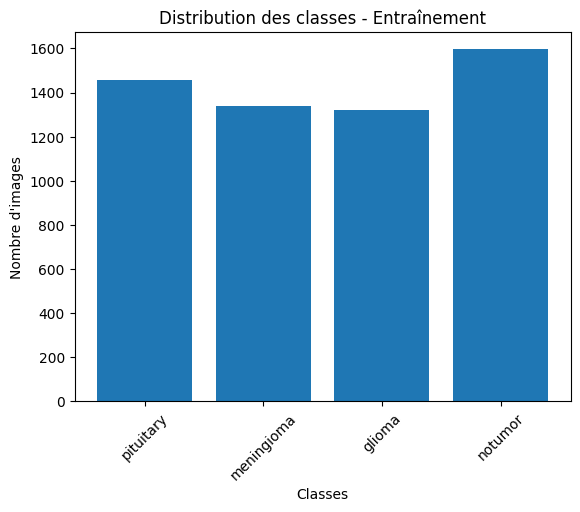

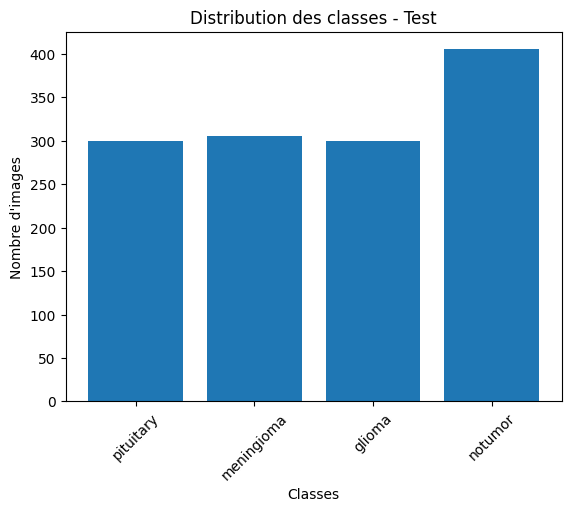

In [67]:
def plot_class_distribution(data_dir, title):
    # Compte le nombre d'images par classe
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(glob.glob(f"{class_path}/*.jpg"))

    # Trace un graphique en barres pour afficher la distribution
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.show()

# Affiche la distribution des classes pour les ensembles d'entraînement et de test
plot_class_distribution(train_dir, "Distribution des classes - Entraînement")
plot_class_distribution(test_dir, "Distribution des classes - Test")

Dimensions des images


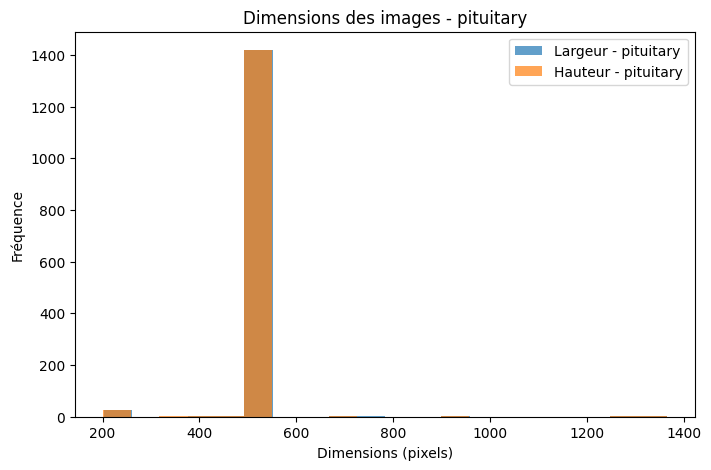

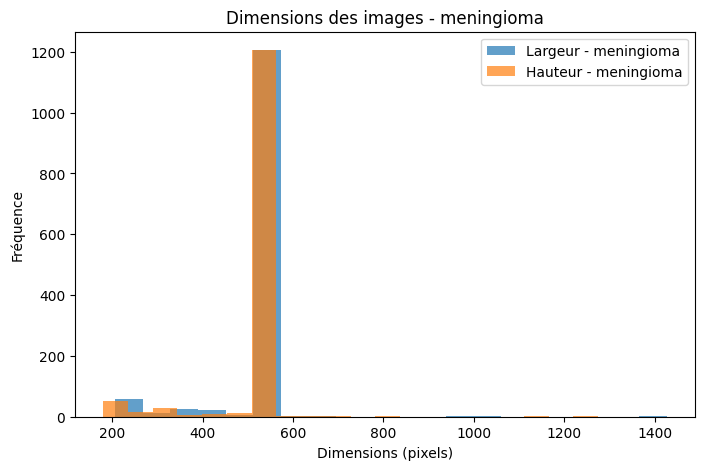

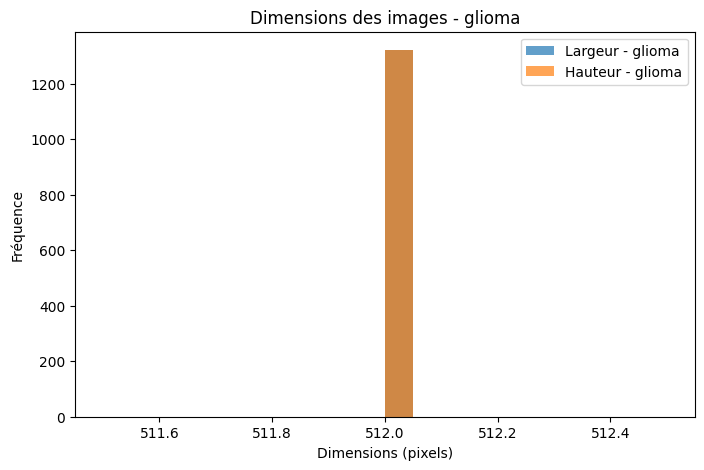

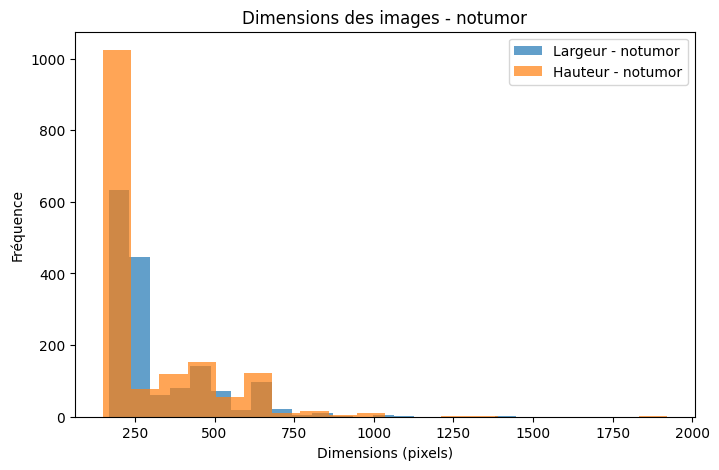

In [68]:
def plot_image_sizes(data_dir, classes):
    # Collecte les dimensions des images pour chaque classe
    image_sizes = {}
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        images = glob.glob(f"{class_path}/*.jpg")
        sizes = [tf.keras.preprocessing.image.load_img(img).size for img in images]
        image_sizes[class_name] = sizes
    return image_sizes

# Récupère les dimensions des images d'entraînement
image_sizes_train = plot_image_sizes(train_dir, train_classes)

# Affiche la distribution des dimensions pour chaque classe
for class_name, sizes in image_sizes_train.items():
    heights, widths = zip(*sizes)
    plt.figure(figsize=(8, 5))
    plt.hist(widths, bins=20, alpha=0.7, label=f"Largeur - {class_name}")
    plt.hist(heights, bins=20, alpha=0.7, label=f"Hauteur - {class_name}")
    plt.title(f"Dimensions des images - {class_name}")
    plt.xlabel("Dimensions (pixels)")
    plt.ylabel("Fréquence")
    plt.legend(loc="upper right")
    plt.show()

Statistiques des pixels des images


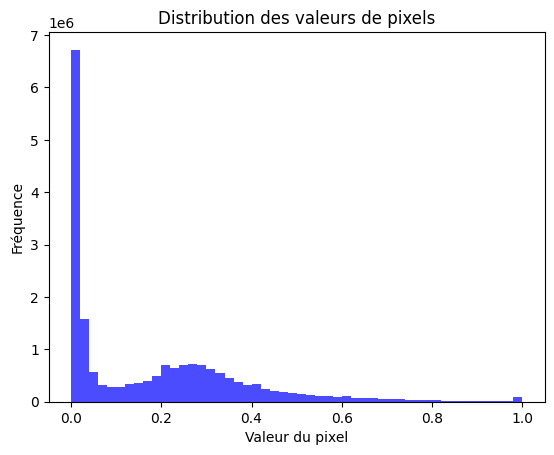

In [69]:
def plot_pixel_values(data_dir, classes, n_samples=100):
    # Collecte des valeurs de pixels pour un échantillon d'images
    pixel_values = []
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        images = glob.glob(f"{class_path}/*.jpg")
        sampled_images = random.sample(images, min(n_samples, len(images)))  # Échantillonnage des images
        for img_path in sampled_images:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))  # Redimensionnement
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalisation
            pixel_values.extend(img_array.flatten())  # Ajout des pixels aplatis

    # Affiche un histogramme des valeurs de pixels
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title("Distribution des valeurs de pixels")
    plt.xlabel("Valeur du pixel")
    plt.ylabel("Fréquence")
    plt.show()

# Affiche la distribution des pixels pour les données d'entraînement
plot_pixel_values(train_dir, train_classes)

Vérification de l'équilibre des données

In [70]:
def check_class_balance(train_dir, test_dir):
    # Compte le nombre d'images par classe dans les ensembles d'entraînement et de test
    train_class_counts = {class_name: len(glob.glob(f"{train_dir}/{class_name}/*.jpg")) for class_name in os.listdir(train_dir)}
    test_class_counts = {class_name: len(glob.glob(f"{test_dir}/{class_name}/*.jpg")) for class_name in os.listdir(test_dir)}

    # Affiche la distribution des classes pour chaque ensemble
    print("Distribution des classes (Entraînement) :", train_class_counts)
    print("Distribution des classes (Test) :", test_class_counts)

# Vérifie l'équilibre des classes dans les ensembles d'entraînement et de test
check_class_balance(train_dir, test_dir)

Distribution des classes (Entraînement) : {'pituitary': 1457, 'meningioma': 1339, 'glioma': 1321, 'notumor': 1595}
Distribution des classes (Test) : {'pituitary': 300, 'meningioma': 306, 'glioma': 300, 'notumor': 405}


Vérification des images corrompues


In [71]:
def check_for_corrupted_images(data_dir, classes):
    # Vérifie si des images sont corrompues dans chaque classe
    corrupted_images = []
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        images = glob.glob(f"{class_path}/*.jpg")
        for img_path in images:
            try:
                # Tente de charger l'image
                img = tf.keras.preprocessing.image.load_img(img_path)
            except (OSError, ValueError):
                # Ajoute les images corrompues à la liste
                corrupted_images.append(img_path)
    return corrupted_images

# Vérifie les images corrompues dans les ensembles d'entraînement et de test
corrupted_train_images = check_for_corrupted_images(train_dir, train_classes)
corrupted_test_images = check_for_corrupted_images(test_dir, train_classes)

# Affiche le nombre d'images corrompues trouvées
print(f"Images corrompues (Entraînement) : {len(corrupted_train_images)}")
print(f"Images corrompues (Test) : {len(corrupted_test_images)}")

Images corrompues (Entraînement) : 0
Images corrompues (Test) : 0


### Préparation des données

Diviser les données en ensembles d'entraînement, de validation et de test.

In [72]:
# Nouveaux dossiers pour les ensembles de données
train_new_dir = '/content/Brain_Tumor_NewDataset/Training'  # Dossier pour l'ensemble d'entraînement
val_dir = '/content/Brain_Tumor_NewDataset/Validation'      # Dossier pour l'ensemble de validation
test_new_dir = '/content/Brain_Tumor_NewDataset/Testing'    # Dossier pour l'ensemble de test

# Créer les dossiers s'ils n'existent pas déjà
os.makedirs(train_new_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_new_dir, exist_ok=True)

In [73]:
# Fonction pour répartir les données en ensembles d'entraînement et de validation
def split_data(source_dir, train_dest, val_dest, split_ratio=0.2):
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = glob.glob(f"{class_path}/*.jpg")
        # Diviser les images en ensembles d'entraînement et de validation
        train_images, val_images = train_test_split(images, test_size=split_ratio, random_state=42)

        # Créer des sous-dossiers pour chaque classe dans les destinations
        os.makedirs(os.path.join(train_dest, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dest, class_name), exist_ok=True)

        # Copier les images dans les dossiers d'entraînement
        for image in train_images:
            shutil.copy(image, os.path.join(train_dest, class_name))
        # Copier les images dans les dossiers de validation
        for image in val_images:
            shutil.copy(image, os.path.join(val_dest, class_name))

# Répartir les données d'entraînement et créer l'ensemble de validation
split_data(train_dir, train_new_dir, val_dir)

# Copier les données de test dans le nouveau dossier sans modification
shutil.copytree(test_dir, test_new_dir, dirs_exist_ok=True)

'/content/Brain_Tumor_NewDataset/Testing'

### Traitement des données

In [74]:
# Préparation des générateurs de données (normalisation)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Charger les données d'entraînement
train_data = train_datagen.flow_from_directory(
    train_new_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Charger les données de validation
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Charger les données de test
test_data = test_datagen.flow_from_directory(
    test_new_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [75]:
print(f"Classes détectées dans le dataset (Train) : {train_data.class_indices}")

Classes détectées dans le dataset (Train) : {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### Mise en place de l'architecture

**Modèle 1 : CNN**

In [76]:
# Définition du modèle de réseau de neurones convolutif (CNN)
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [77]:
# Structure du modèle
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

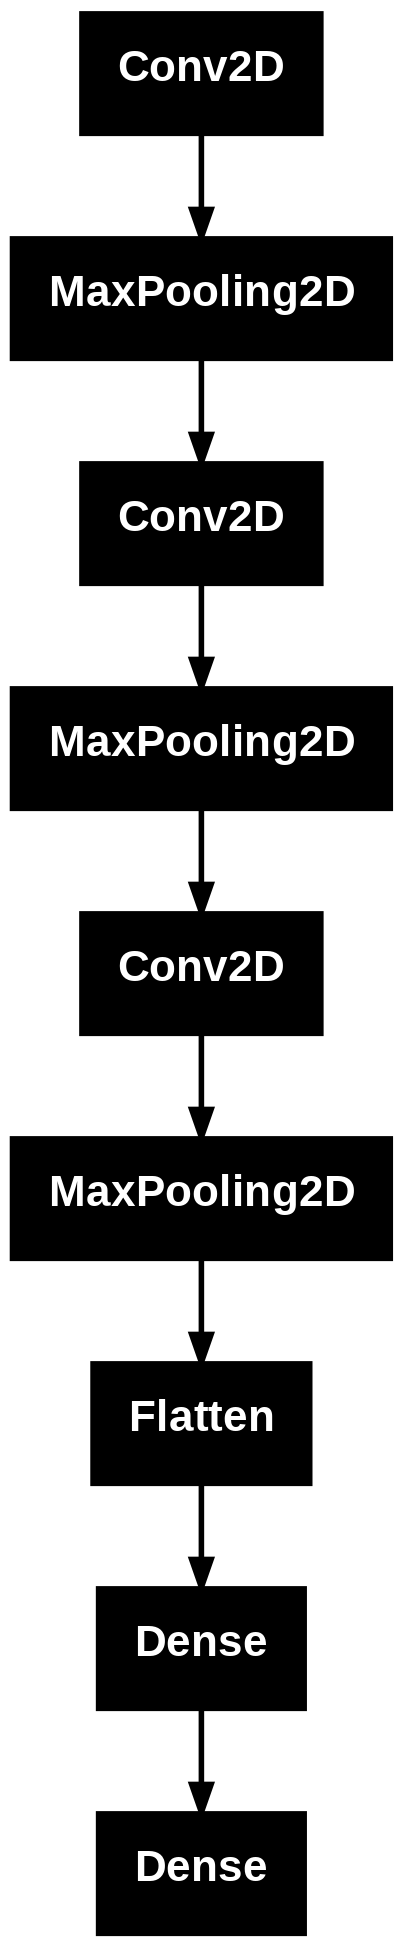

In [78]:
# Architecture du modèle
keras.utils.plot_model(model1)

**Modèle 2 : CNN + Dropout**

In [79]:
# Définition du modèle de réseau de neurones convolutif (CNN) avec Dropout
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),  # Régularisation
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [80]:
# Structure du modèle
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

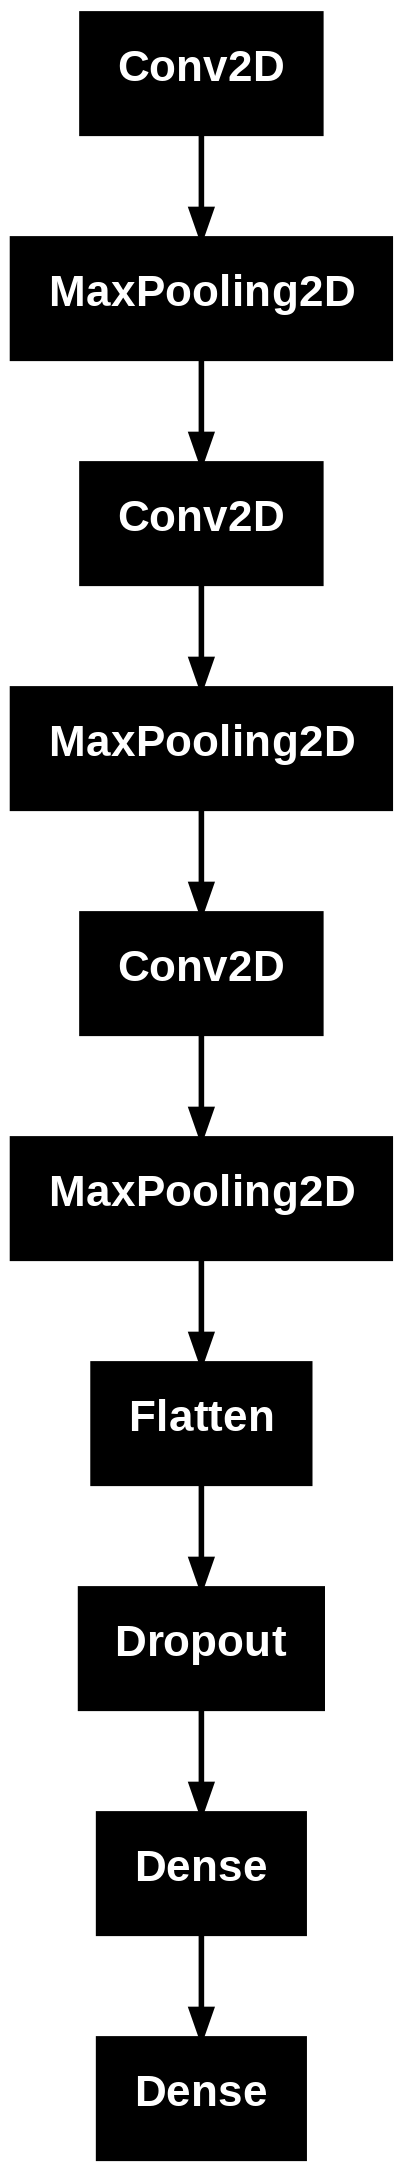

In [81]:
# Architecture du modèle
keras.utils.plot_model(model2)

### Entraînement des modèles

In [82]:
# Compilation des modèles
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print("Training Model 1...")
# Entraînement du modèle 1
history1 = model1.fit(train_data, validation_data=val_data, epochs=10)

Training Model 1...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.6071 - loss: 0.9341 - val_accuracy: 0.8409 - val_loss: 0.4357
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8424 - loss: 0.3960 - val_accuracy: 0.8942 - val_loss: 0.3039
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9171 - loss: 0.2460 - val_accuracy: 0.9231 - val_loss: 0.2480
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9511 - loss: 0.1465 - val_accuracy: 0.9222 - val_loss: 0.2052
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9716 - loss: 0.0823 - val_accuracy: 0.9397 - val_loss: 0.2026
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9756 - loss: 0.0627 - val_accuracy: 0.9353 - val_loss: 0.2805
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9857 - loss: 0.0441 - val_accuracy: 0.9135 - val_loss: 0.3154
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9915 - loss: 0.0286 - val_accuracy: 0.926

In [ ]:
def plot_training_history(history):
    # Perte
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entraînement')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Évolution de la perte')
    plt.xlabel('Épochs')
    plt.ylabel('Perte')
    plt.legend()

    # Précision
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entraînement')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Évolution de la précision')
    plt.xlabel('Épochs')
    plt.ylabel('Précision')
    plt.legend()
    plt.show()

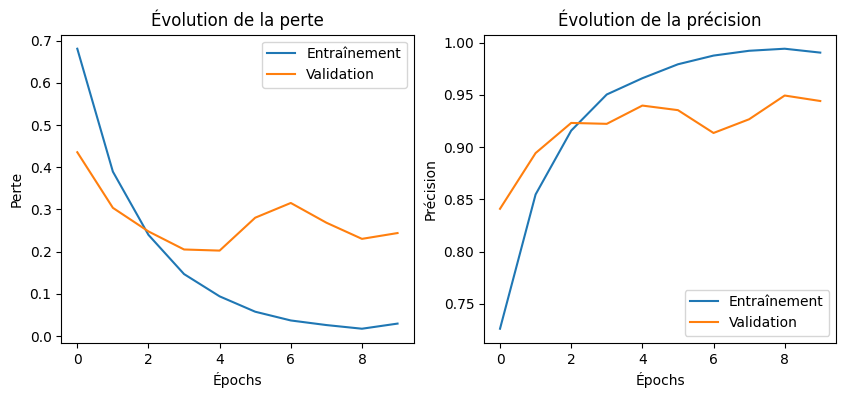

In [ ]:
plot_training_history(history1)

In [ ]:
print("Training Model 2...")
# Entraînement du modèle 2
history2 = model2.fit(train_data, validation_data=val_data, epochs=10)

Training Model 2...
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.5816 - loss: 0.9724 - val_accuracy: 0.8392 - val_loss: 0.4084
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8495 - loss: 0.3804 - val_accuracy: 0.8689 - val_loss: 0.3613
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9019 - loss: 0.2705 - val_accuracy: 0.9047 - val_loss: 0.2729
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9373 - loss: 0.1797 - val_accuracy: 0.9108 - val_loss: 0.2535
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9534 - loss: 0.1319 - val_accuracy: 0.9336 - val_loss: 0.2007
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9719 - loss: 0.0849 - val_accuracy: 0.9414 - val_loss: 0.1818
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9843 - loss: 0.0532 - val_accuracy: 0.9309 - val_loss: 0.2398
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9843 - los

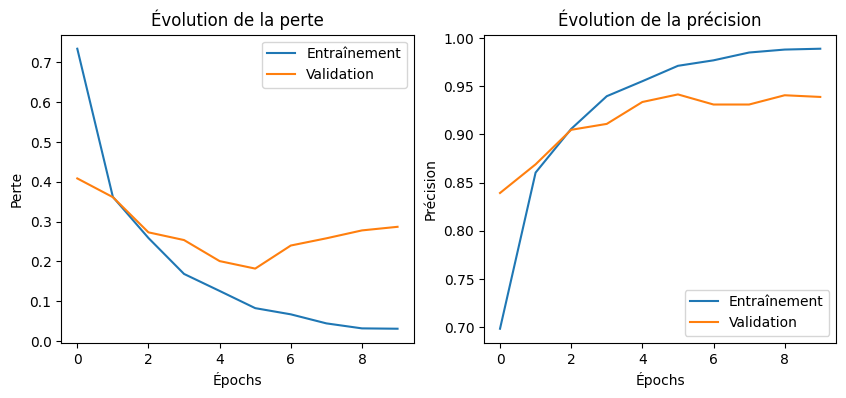

In [ ]:
plot_training_history(history2)

### Évaluation du modèle

In [ ]:
print("Evaluating Model 1...")
# Évaluation du modèle 1
loss1, acc1 = model1.evaluate(test_data)
print(f"Model 1 - Test Accuracy: {acc1:.2f}")

Evaluating Model 1...
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 430ms/step - accuracy: 0.9623 - loss: 0.1639
Model 1 - Test Accuracy: 0.96


In [ ]:
print("\nEvaluating Model 2...")
# Évaluation du modèle 2
loss2, acc2 = model2.evaluate(test_data)
print(f"Model 2 - Test Accuracy: {acc2:.2f}")


Evaluating Model 2...
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 348ms/step - accuracy: 0.9506 - loss: 0.2301
Model 2 - Test Accuracy: 0.95


Comparaison des Performances des Modèles 1 et 2

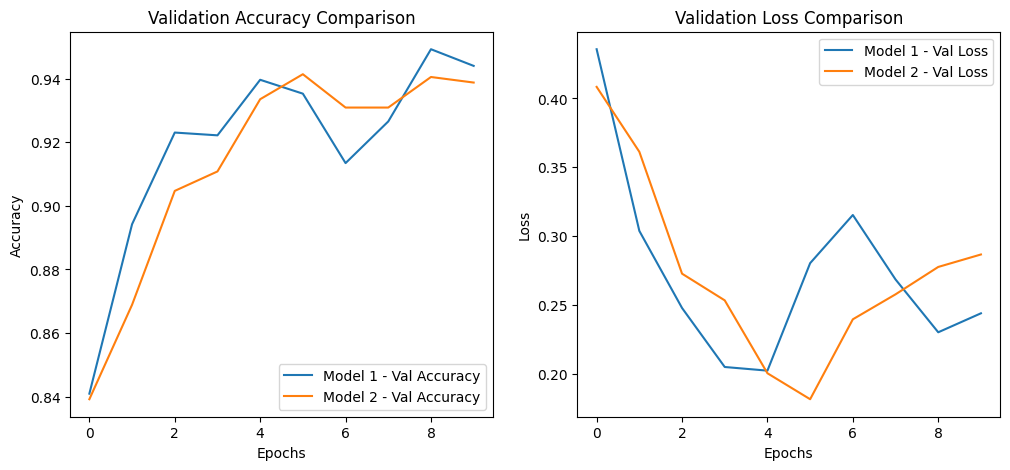

In [ ]:
# Comparaison des performances
plt.figure(figsize=(12, 5))

# Précision de validation
plt.subplot(1, 2, 1)
plt.plot(history1.history['val_accuracy'], label="Model 1 - Val Accuracy")
plt.plot(history2.history['val_accuracy'], label="Model 2 - Val Accuracy")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Perte de validation
plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], label="Model 1 - Val Loss")
plt.plot(history2.history['val_loss'], label="Model 2 - Val Loss")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

**Best modèle**

In [ ]:
# Sélection du meilleur modèle
best_model = model1 if acc1 > acc2 else model2
best_model_name = "Model 1" if acc1 > acc2 else "Model 2"
print(f"\nThe best model is: {best_model_name}")


The best model is: Model 1


In [ ]:
# Prédictions et métriques
y_pred = best_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 396ms/step


Classification report


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.26      0.24      0.25       300
  meningioma       0.21      0.21      0.21       306
     notumor       0.30      0.31      0.31       405
   pituitary       0.27      0.28      0.27       300

    accuracy                           0.26      1311
   macro avg       0.26      0.26      0.26      1311
weighted avg       0.26      0.26      0.26      1311



Accuracy score

In [ ]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.25


F1 Score

In [ ]:
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"F1 Score (weighted): {f1:.2f}")

F1 Score (weighted): 0.25


Matrice de confusion

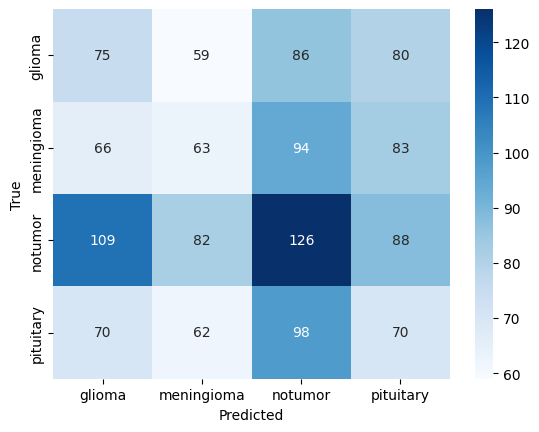

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AUC

In [83]:
# Binariser les étiquettes pour la courbe ROC et l'AUC
num_classes = len(test_data.class_indices)
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Calculer la courbe ROC et l'AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculer l'AUC moyenne (macro et micro)
macro_auc = roc_auc_score(y_true_bin, y_pred, average="macro", multi_class="ovr")
micro_auc = roc_auc_score(y_true_bin, y_pred, average="micro", multi_class="ovr")

print(f"AUC Macro: {macro_auc:.2f}")
print(f"AUC Micro: {micro_auc:.2f}")

AUC Macro: 0.49
AUC Micro: 0.50


Courbe ROC

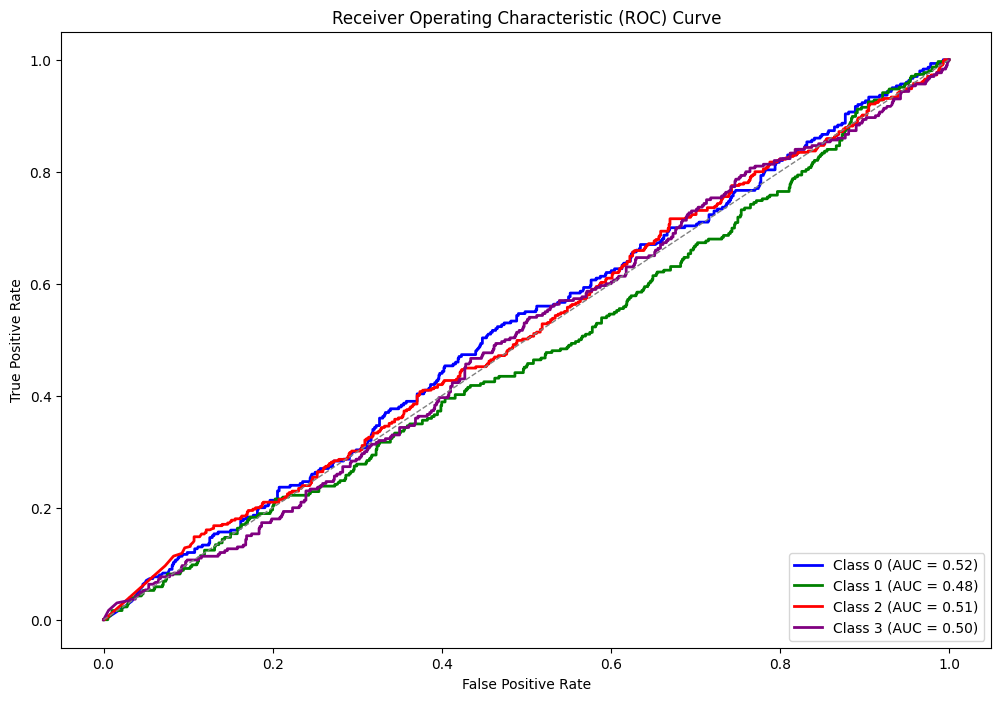

In [ ]:
# Tracer la courbe ROC pour chaque classe
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Ajouter une ligne diagonale pour la référence
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Configurer le graphique
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

### Prédictions du modèle

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


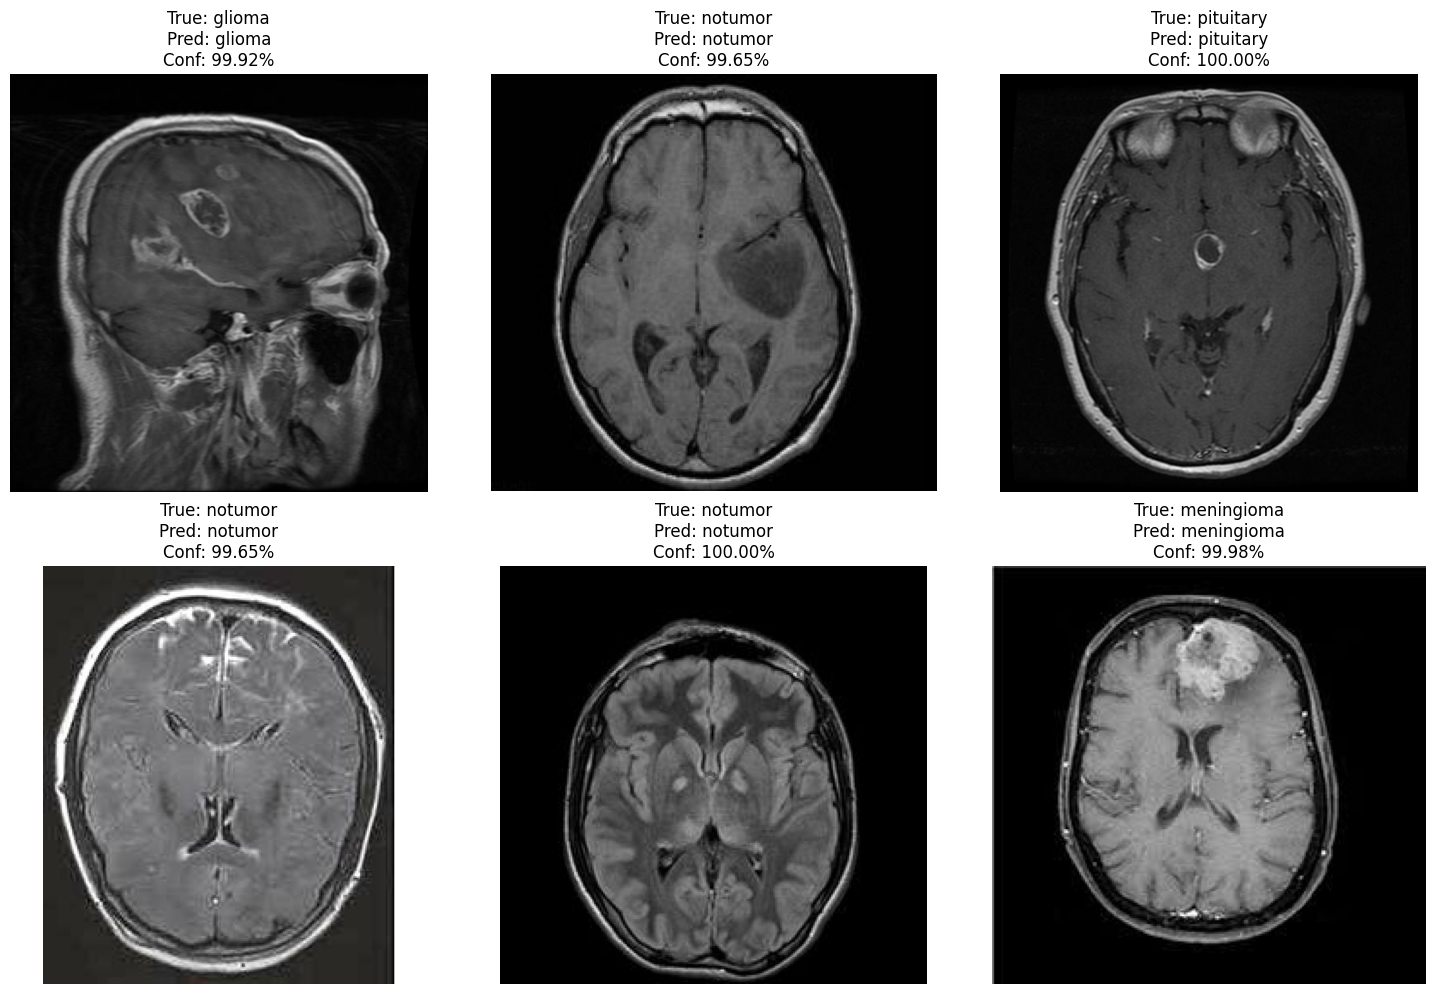

In [ ]:
# Sélection aléatoire de 6 images à partir des données de test
image_paths = []
true_labels = []
for class_label in test_data.class_indices.keys():
    class_dir = os.path.join('/content/Brain_Tumor_NewDataset/Testing', class_label)
    images = os.listdir(class_dir)
    image_paths += [os.path.join(class_dir, img) for img in images]
    true_labels += [class_label] * len(images)

# Associer les images à leurs vraies classes
all_images = list(zip(image_paths, true_labels))
selected_images = random.sample(all_images, 6)

# Préparer une figure pour afficher les images
plt.figure(figsize=(15, 10))

for i, (image_path, true_label) in enumerate(selected_images):
    # Charger et prétraiter l'image
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prédiction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = list(test_data.class_indices.keys())[predicted_class_index]
    predicted_probability = prediction[0][predicted_class_index] * 100

    # Affichage des résultats
    plt.subplot(2, 3, i + 1)
    plt.imshow(load_img(image_path))
    plt.axis("off")
    plt.title(
        f"True: {true_label}\nPred: {predicted_class_label}\nConf: {predicted_probability:.2f}%",
        fontsize=12
    )

plt.tight_layout()
plt.show()
